In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

In [2]:
target = 'poisson'

In [7]:
results = []
for trial in os.listdir('denoise/'):
    if trial.split('_')[0] == target and '07-1' in trial and 'householder' not in trial:
        if len(trial.split('_')) != 8:
            results.append(trial)
        
results.sort()
results

['poisson_0#0.05_None_None_random_0.5_07-13-2021 12:39',
 'poisson_0#0.05_None_None_random_1.1344_07-13-2021 12:36']

In [8]:
def load_trained(path):
    path = os.path.join('denoise', path)
    residual_curve = np.load(os.path.join(path, 'residual_curve.npy'))
    psnr_curve = np.load(os.path.join(path, 'psnr_curve.npy'))
    try: 
        gamma_curve = np.load(os.path.join(path, 'gamma_curve.npy'))
    except:
        gamma_curve = None
        
    noise = np.load(os.path.join(path, 'noise.npy'))
    noisy = np.load(os.path.join(path, 'noisy.npy'))
    original = np.load(os.path.join(path, 'original.npy'))
    
    base_noisy = np.load(os.path.join(path, 'base_noisy.npy'))
    base_original = np.load(os.path.join(path, 'base_original.npy'))
    
    recovered_cps = [str(x) for x in Path(path).glob("**/recovered_*.npy")]
    recovered_cps.sort()
    base_cps = [str(x) for x in Path(path).glob("**/base_*.npy") if 'noisy' not in str(x) and 'original' not in str(x)]
    base_cps.sort()
    
    return noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve, gamma_curve

def l2norm(batch_data):
    return np.sqrt((batch_data ** 2).reshape(len(batch_data), -1).sum(1))

noise_scale=0.05, (fina) gamma=0.5, basenorm_original=[122.14121  122.23843  123.46659  125.012985], basenorm_noisy=[199.35619 182.13933 195.76927 180.20096]


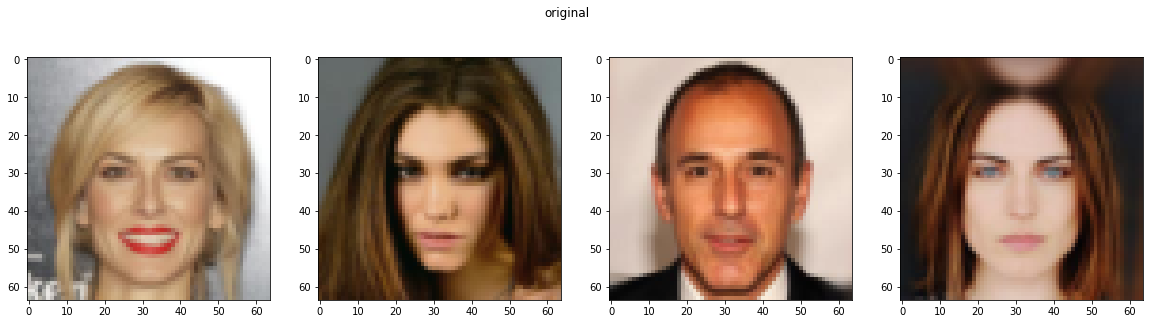

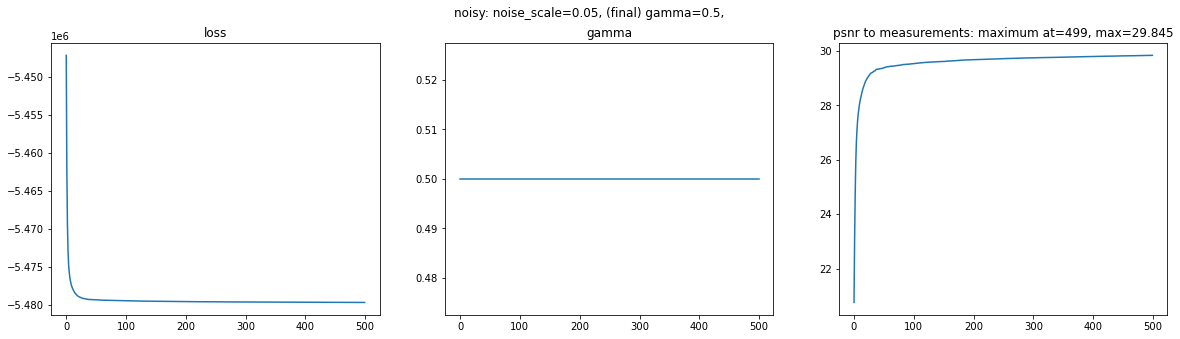

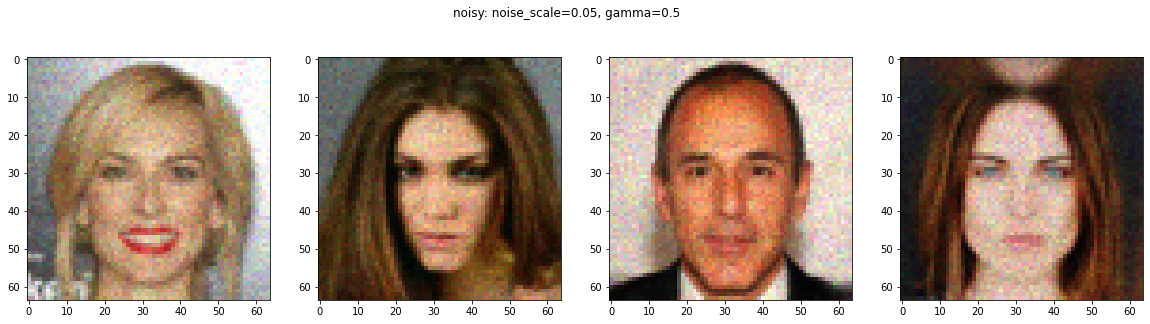

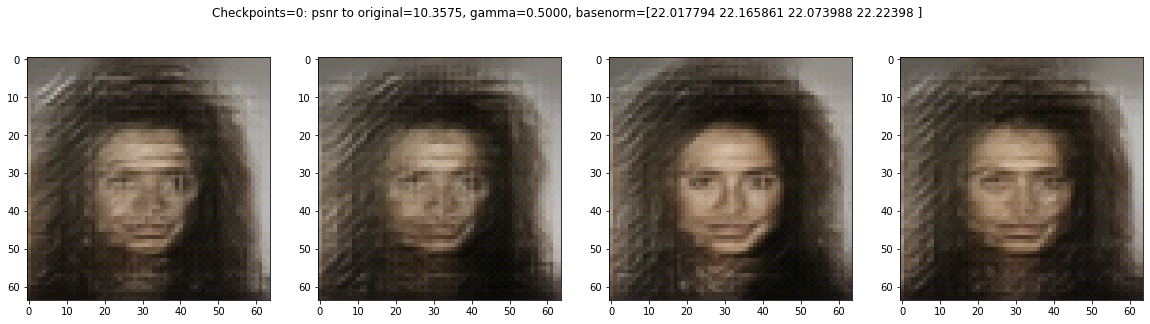

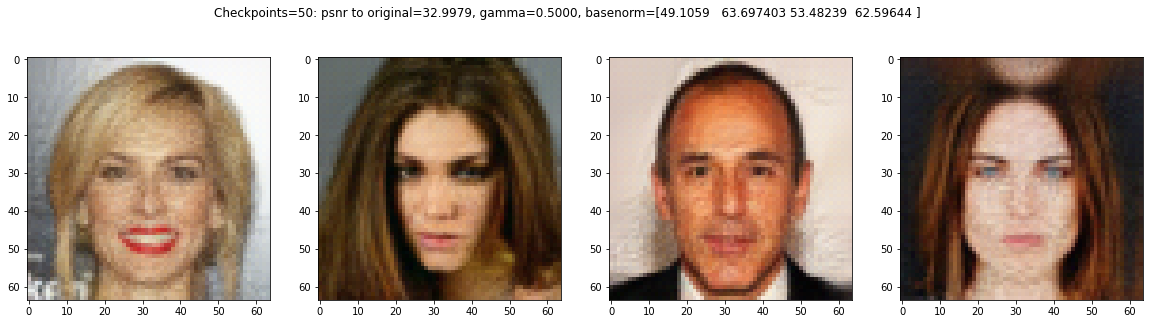

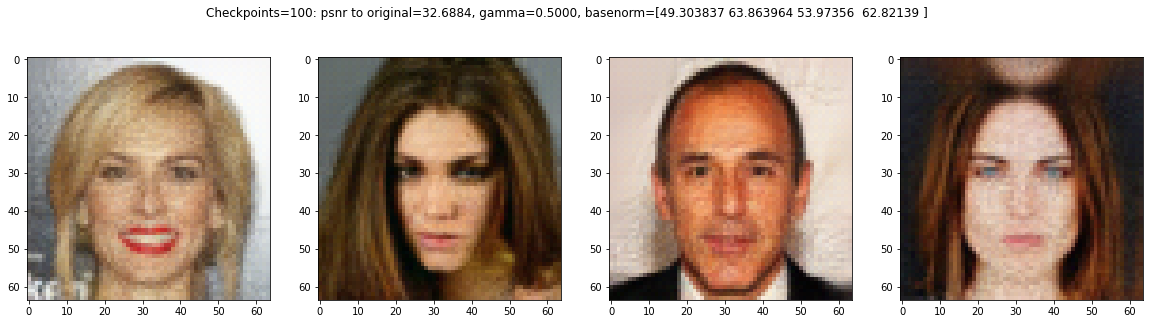

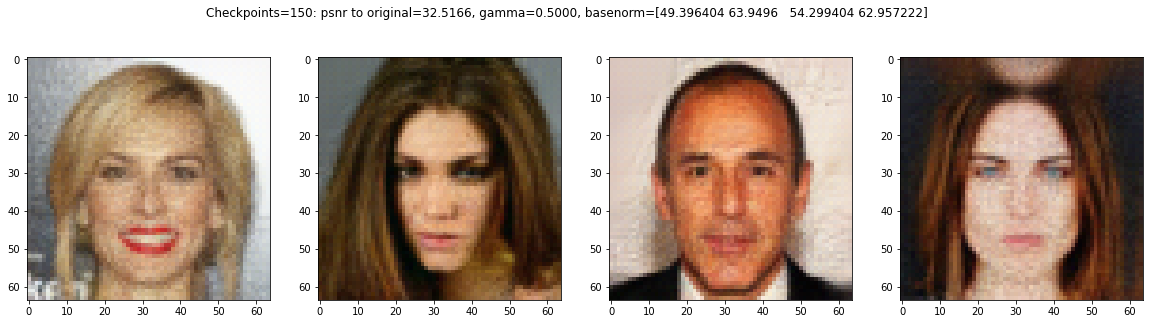

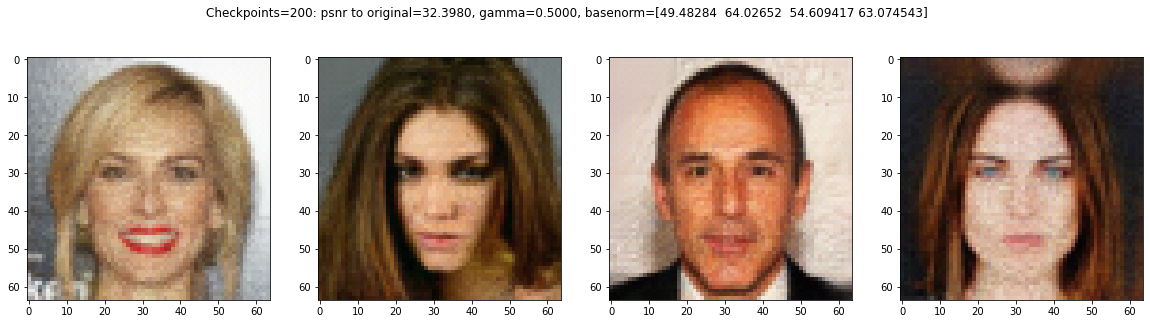

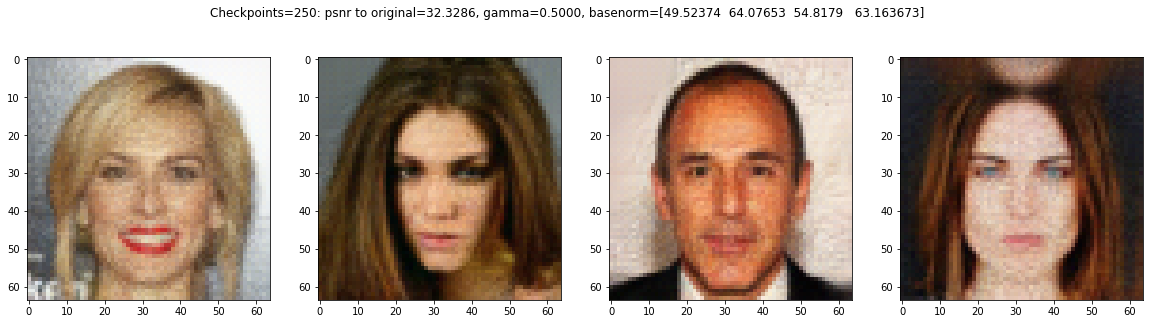

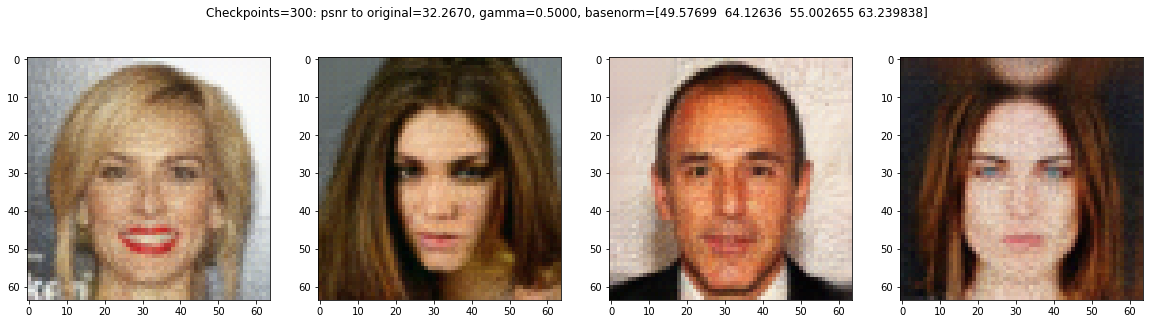

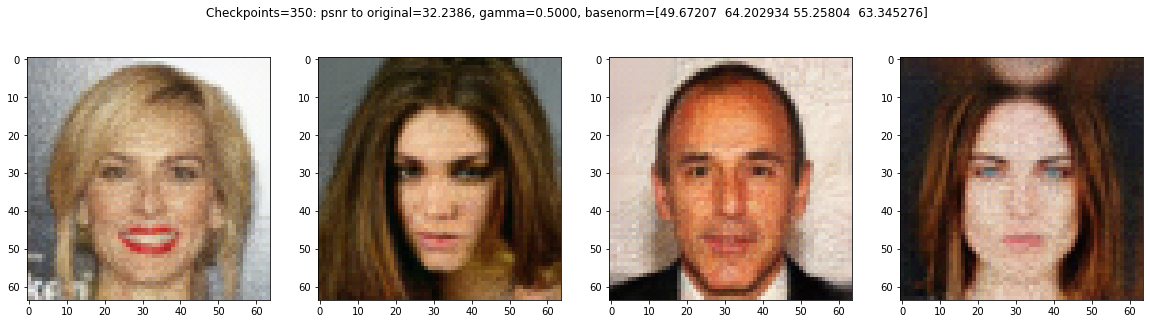

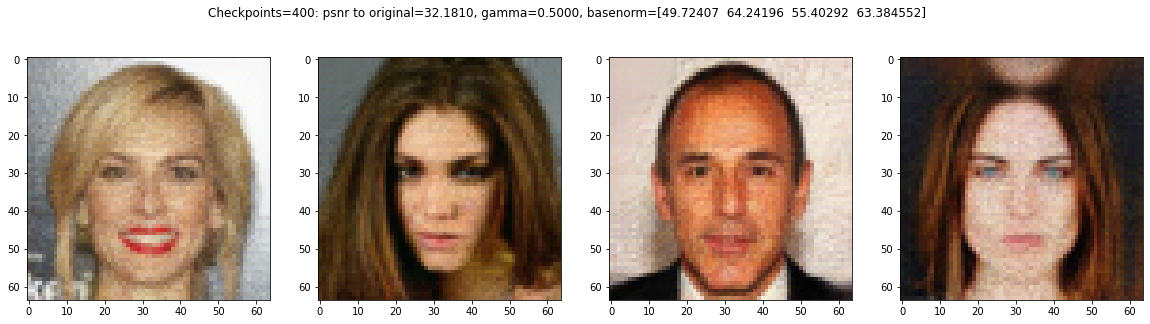

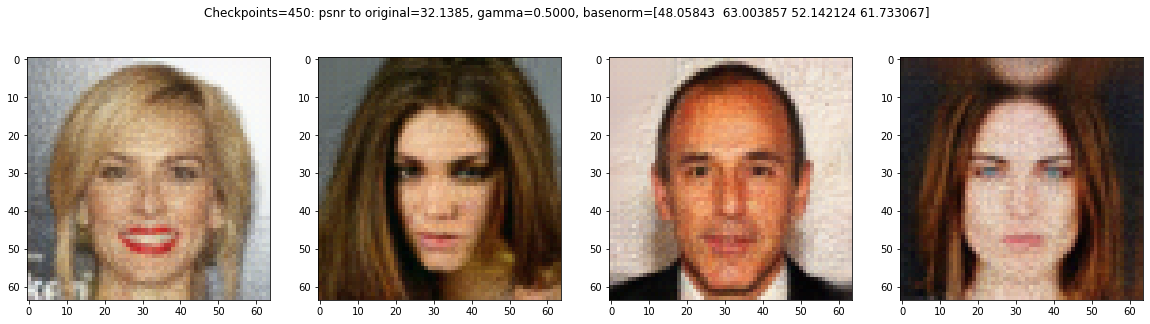

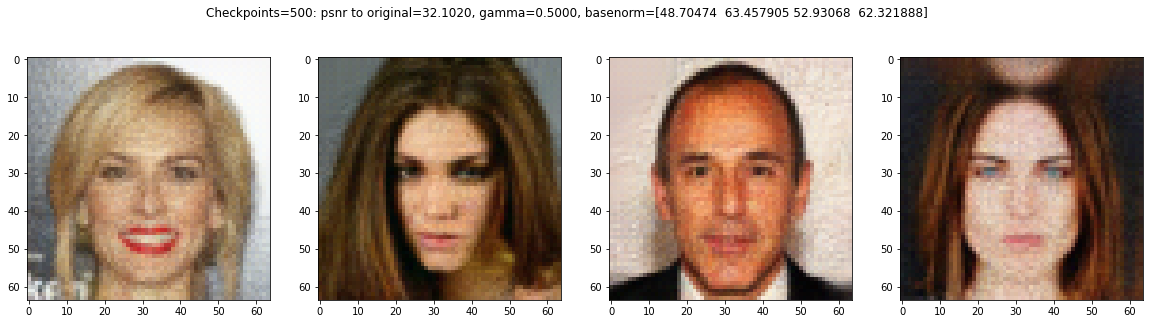





noise_scale=0.05, (fina) gamma=1.1344, basenorm_original=[121.73873 124.30382 123.43139 124.16876], basenorm_noisy=[198.8175  181.86447 194.80681 179.62401]


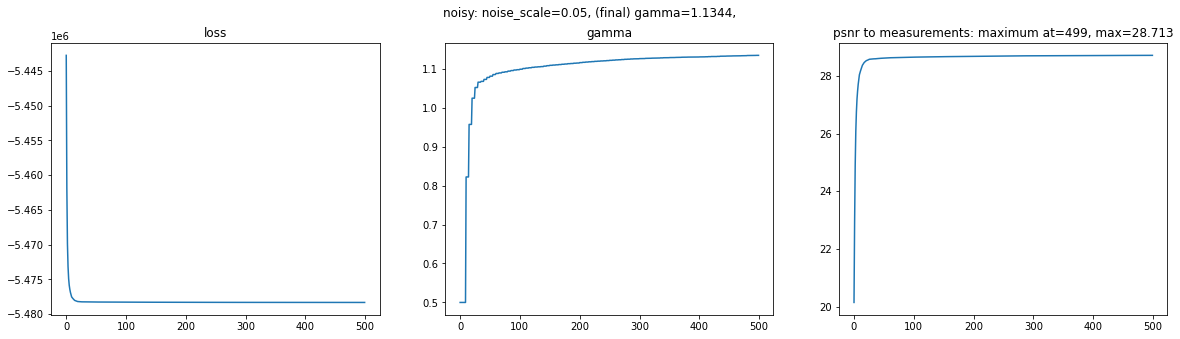

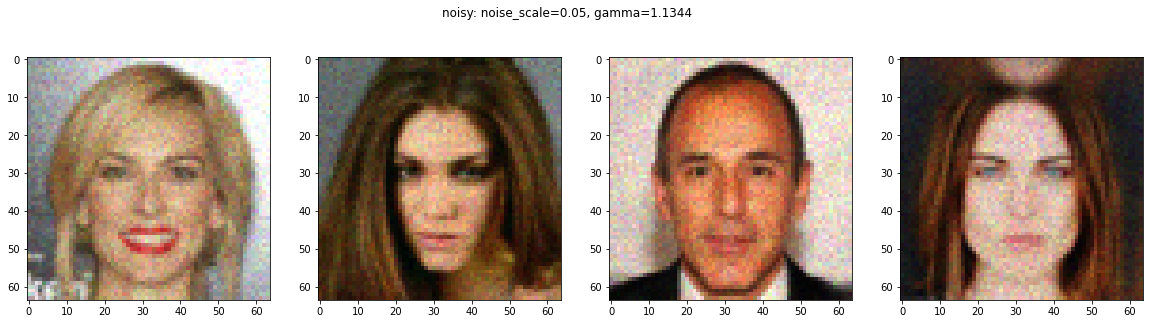

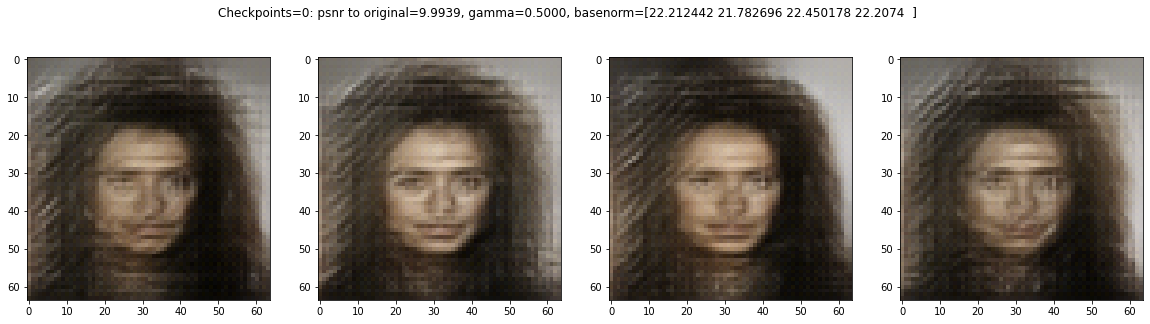

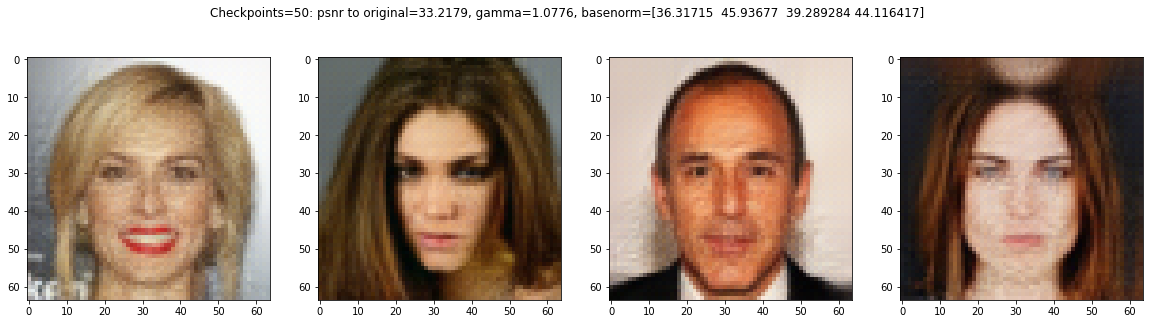

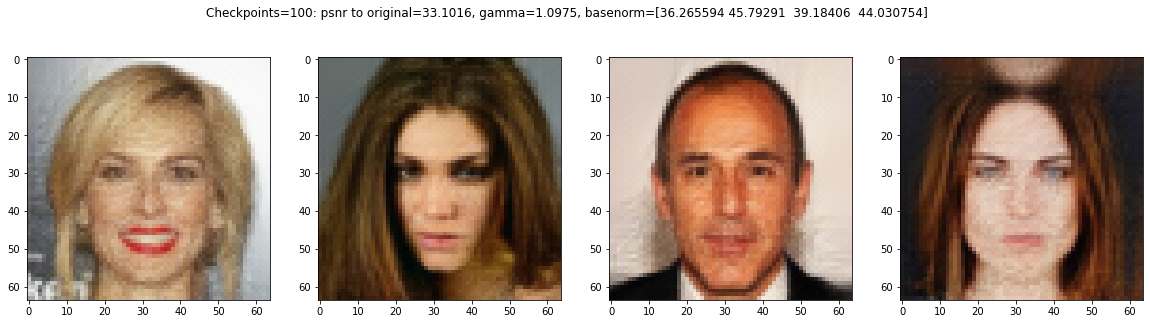

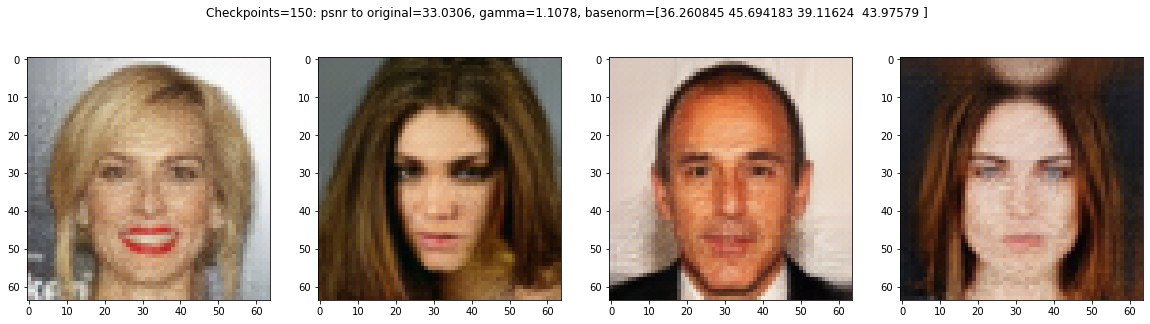

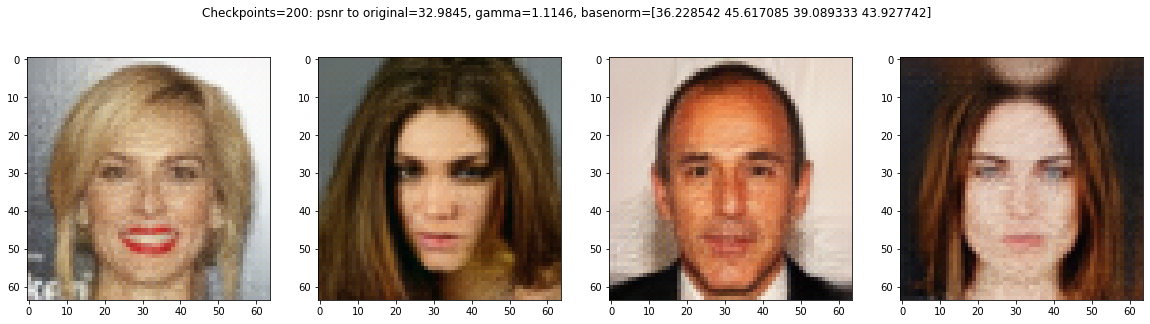

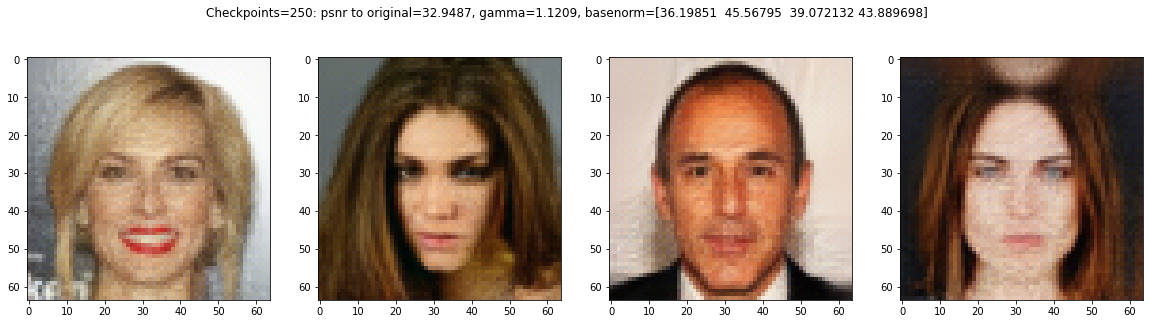

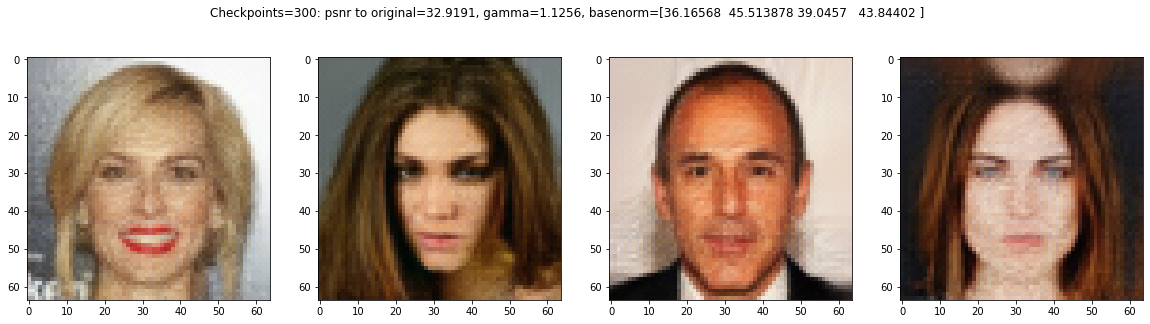

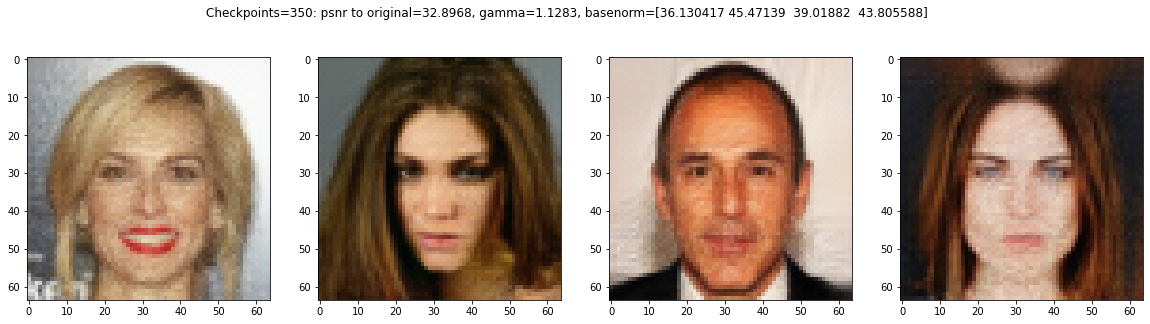

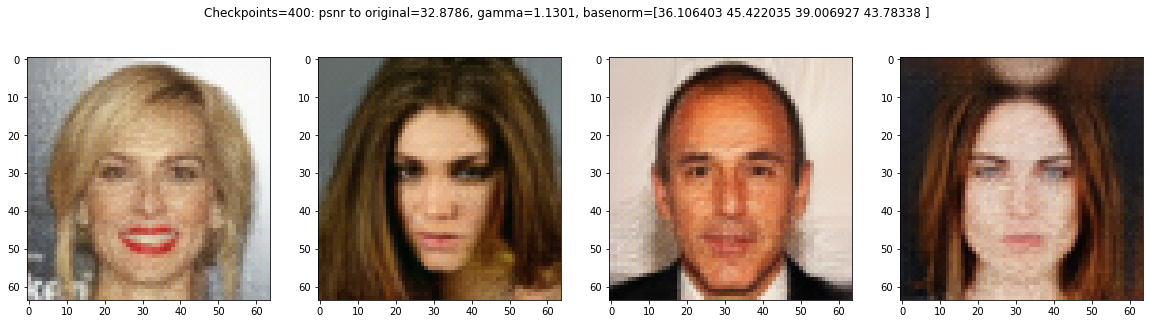

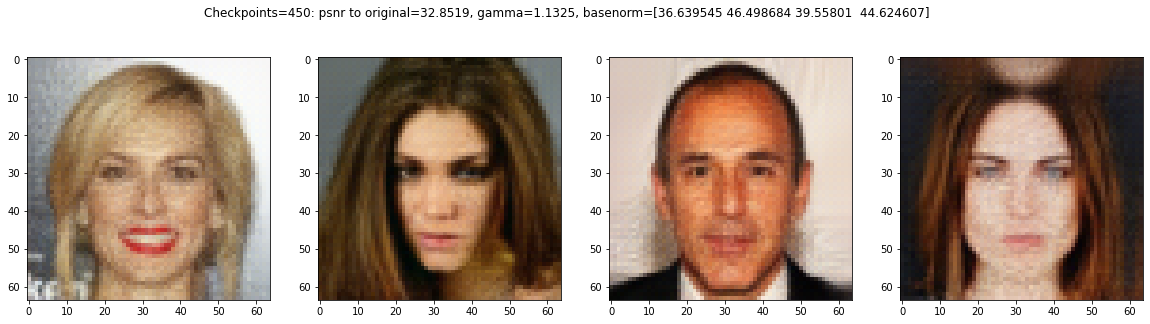

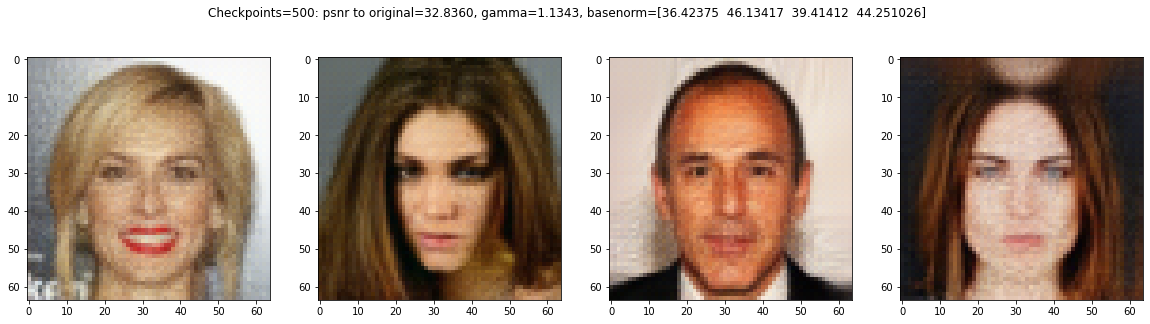

In [9]:
original_showed = False

for trial in results:
    gamma = trial.split('_')[5]
    noise_info = trial.split('_')[1]
    noise_loc, noise_scale = noise_info.split('#')
    noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve, gamma_curve = load_trained(trial)
    if gamma_curve is None:
        gamma_curve = np.full_like(psnr_curve, float(gamma))
    print(f'noise_scale={noise_scale}, (fina) gamma={gamma}, basenorm_original={l2norm(base_original)}, basenorm_noisy={l2norm(base_noisy)}')

    if len(recovered_cps) > 0 and len(base_cps) > 0:
#         print(f'noise_scale={noise_scale}, gamma={gamma}, basenorm_original={l2norm(base_original)}, basenorm_noisy={l2norm(base_noisy)}')
        if not original_showed:
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
            for ori, ax in zip(original, axes):
                ax.imshow(ori.transpose(0, 1, 2))
            _ = plt.suptitle(f'original')
            _ = plt.show()
            original_showed = True
            
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        _ = ax1.plot(residual_curve)
        _ = ax1.set_title(f'loss')

        _ = ax2.plot(gamma_curve)
        _ = ax2.set_title(f'gamma')
        
        _ = ax3.plot(psnr_curve)
        _ = ax3.set_title(f'psnr to measurements: maximum at={np.argmax(psnr_curve)}, max={np.max(psnr_curve):.3f}')
        
        _ = plt.suptitle(f'noisy: noise_scale={noise_scale}, (final) gamma={gamma}, ')
        _ = plt.show()
        
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        for noisy, ax in zip(noisy, axes):
            ax.imshow(noisy.transpose(0, 1, 2))
        _ = plt.suptitle(f'noisy: noise_scale={noise_scale}, gamma={gamma}')
        _ = plt.show()
    
        recovered_cps.sort(key=lambda h: int(h.split('_')[-1].replace('.npy', '')))
        for recovered, base in zip(recovered_cps, base_cps):
            checkpoints = recovered.split('_')[-1].replace('.npy', '')
            
            if int(checkpoints) % 50 == 0:
                recovered = np.load(recovered)
                base = np.load(base)

                psnr = [compare_psnr(x, y) for x,y in zip(original, recovered)]
                fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
                for recover, ax in zip(recovered, axes):
                    ax.imshow(recover.transpose(0, 1, 2))
                gamma_checkpoint = gamma_curve[max(int(checkpoints) - 1, 0)]
                _ = plt.suptitle(f'Checkpoints={checkpoints}: psnr to original={np.mean(psnr):.4f}, gamma={gamma_checkpoint:.4f}, basenorm={l2norm(base)}')
                _ = plt.show()
    else:
        print('Failed')
    print('\n' * 3)